In [22]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas import DataFrame as df
from IPython.display import display
#from pandas import set_option
#from pandas.plotting import scatter_matrix
import re
from collections import Counter

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,ShuffleSplit,StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report,make_scorer,fbeta_score,roc_auc_score
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor

In [2]:
# *load data*
train_data=pd.read_csv('train.csv')

In [3]:
# *split data into X and y*
y=df(train_data['target'],columns=['target'])
X=train_data.drop(['target','id'],axis=1)

## Data Exploration
### 1) Prepare Data
Reasons for splitting the dataset into various subsets for exploratory analysis:
* there're too many attributes to view at once
* intuitively, given it's car insurance, some attributes should be more correlated than others (e.g. attributes about individuals `'_Ind'` versus cars `'_Car'`) 
* split by data type, such as categorical and continuous, for different treatment in certain functionalities (e.g. `'DecisionTreeClassifier'` vs. `'DecisionTreeRegressor'`) and visualizations

Dataset is split by source of attribute (individual vs. region vs. car), data type (binary vs. categorical vs. ordinal vs. continuous, and integer vs. float), and various combinations of both when needed. Code for splitting dataset is below:

In [4]:
# column names split by Individual vs. Car vs. Region (vs. Calc)
ind_col=[col for col in X.columns if '_ind_' in col]
car_col=[col for col in X.columns if '_car_' in col]
reg_col=[col for col in X.columns if '_reg_' in col]
calc_col=[col for col in X.columns if '_calc_' in col]

# column names split by Binary, Categorical, Ordinal vs. Continuous
bin_col=[col for col in X.columns if '_bin' in col]
cat_col=[col for col in X.columns if '_cat' in col]
temp=[col for col in X.columns if '_cat' not in col and '_bin' not in col]

In [5]:
# make separate and combined dataframes for groupings identified above
# dataframes by Individual vs. Car vs. Region (vs. Calc) 
X_ind=X[ind_col]
X_car=X[car_col]
X_reg=X[reg_col]
X_calc=X[calc_col]
# further split by Integer vs. Float for 'relevance_score' function (regressor vs. classifier)
X_car_integer=X_car.select_dtypes(include=['int64'])
X_car_float=X_car.select_dtypes(include=['float64'])
X_calc_integer=X[calc_col].select_dtypes(include=['int64'])
X_calc_float=X[calc_col].select_dtypes(include=['float64'])
# combining subsets for correlations
X_ind_car=pd.concat([X_ind,X_car],axis=1)
X_reg_car=pd.concat([X_reg,X_car],axis=1)
X_ind_reg=pd.concat([X_ind,X_reg],axis=1)
X_ind_calc=pd.concat([X_ind,X_calc],axis=1)
X_reg_calc=pd.concat([X_reg,X_calc],axis=1)
X_car_calc=pd.concat([X_car,X_calc],axis=1)
X_ind_car_reg=pd.concat([X_car,X_reg,X_ind],axis=1)
X_ind_y=pd.concat([X_ind,y],axis=1)
X_car_y=pd.concat([X_car,y],axis=1)
X_reg_y=pd.concat([X_reg,y],axis=1)
X_calc_y=pd.concat([X_calc,y],axis=1)

# dataframes by Binary, Categorical, Ordinal vs. Continuous
X_bin=X[bin_col]
X_cat=X[cat_col]
X_ord=X[temp].select_dtypes(include=['int64'])
X_cont=X[temp].select_dtypes(include=['float64'])
X_bin_y=pd.concat([X_bin,y],axis=1)
X_cat_y=pd.concat([X_cat,y],axis=1)
X_ord_y=pd.concat([X_ord,y],axis=1)
X_cont_y=pd.concat([X_cont,y],axis=1)

### 2) Explore Feature Relevance

There are various methods for finding out which attributes are relevant for understanding whether a policyholder will file a claim. Because the data is anonymous, rather than relying on intuition, we can systematically test whether a given attribute adds any additional information by first removing it and then scoring how well a trained learner can predict the removed attribute with the remaining subset as `X` and removed feature as `y`. In other words, if an attribute is highly correlated with the rest in its group, then it might not be relevant and we might consider removing it from our features set. 

The function `'relevance_score'` returns the score for a given subset, the feature to be removed, and an appropriate learner. For example, for the region attributes subset, I used a `'DecisionTreeRegressor'` to score the relevance of each individual attribute.   

In [ ]:
def relevance_score(data,feature,model):
    temp_X=data.copy(deep=True)
    temp_y=df(temp_X[feature])
    temp_X.drop(feature,axis=1,inplace=True)
    X_train,X_test,y_train,y_test = train_test_split(temp_X,temp_y,test_size=0.2,random_state=88)
    model.fit(X_train,y_train)
    score=model.score(X_test,y_test)
    return score

In [ ]:
dtr=DecisionTreeRegressor()
dtc=DecisionTreeClassifier()

In [ ]:
print('Region attribute scores:')
for col in X_reg:
    score=relevance_score(X_reg,col,dtr)
    print(col,score)

In [ ]:
print('Car attribute scores:')
for col in X_car_integer:
    score=relevance_score(X_car,col,dtc)
    print(col,score)
for col in X_car_float:
    score=relevance_score(X_car,col,dtr)
    print(col,score)

In [ ]:
print('Individual attribute scores:')
for col in X_ind:
    score=relevance_score(X_ind,col,dtc)
    print(col,score)

### 3) Visualize Feature Distributions
Use visualizations to help explore:
* feature scaling including normality, outliers, etc.
* correlations, such as confirming aforementioned feature relevance scores 
* feature engineering

#### Univariate Distributions

In [ ]:
# produce histograms for all BINARY attributes
for col in X_bin_y.columns:
    g=sns.FacetGrid(X_bin_y,col='target',palette='Set2',hue='target',size=5)
    g.map(plt.hist,col);

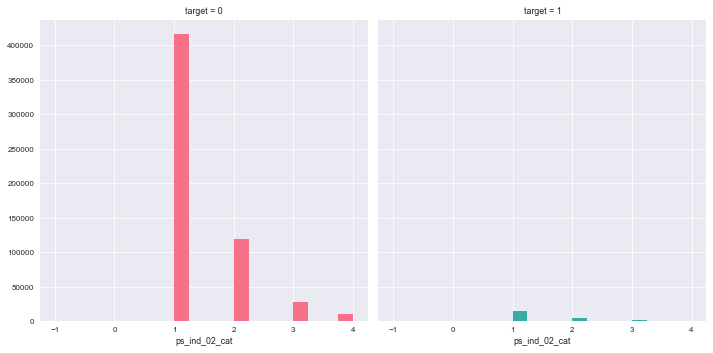

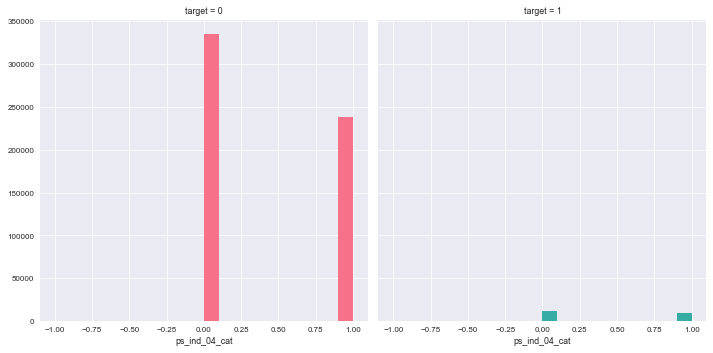

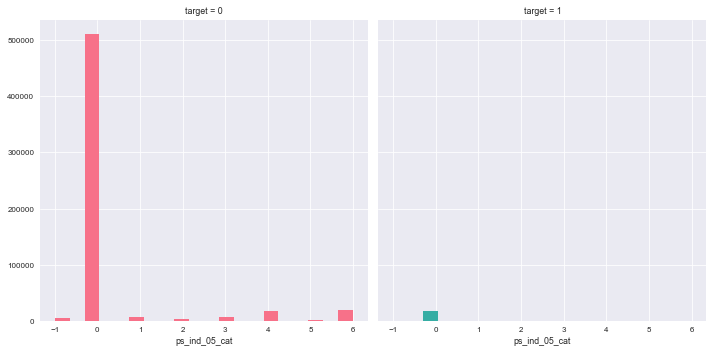

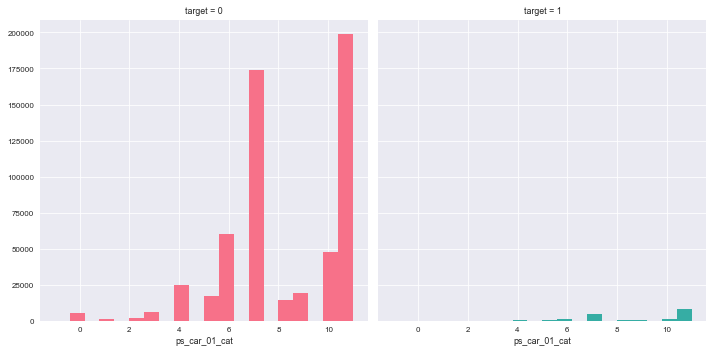

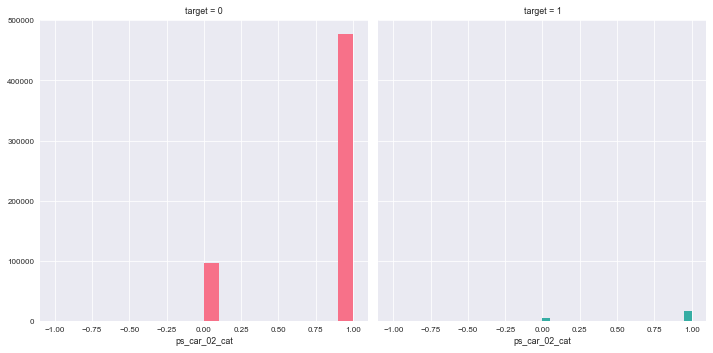

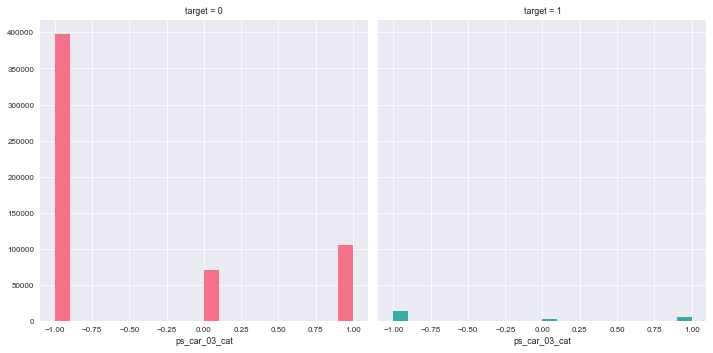

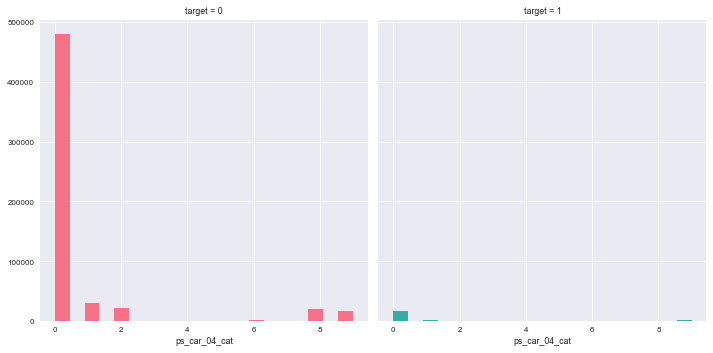

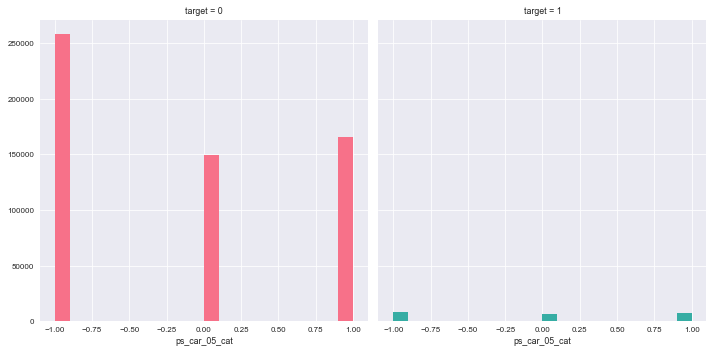

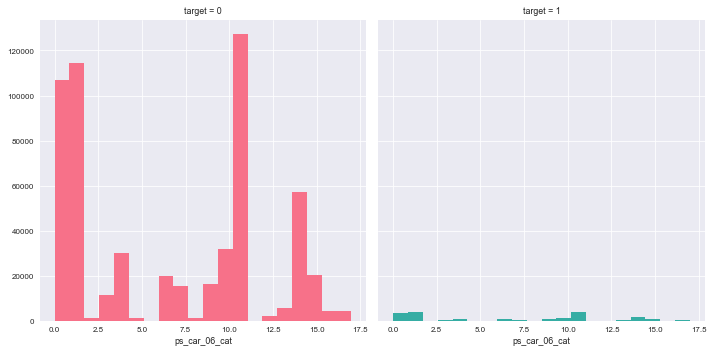

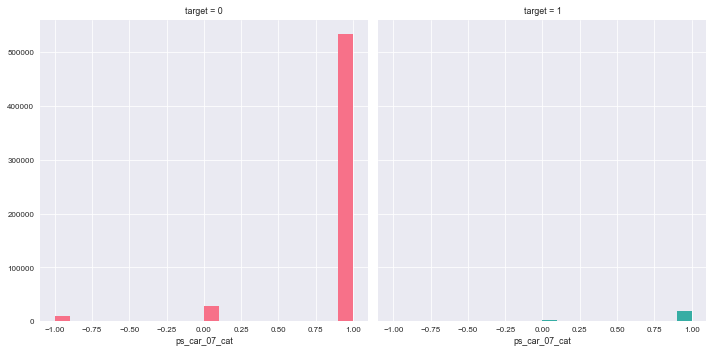

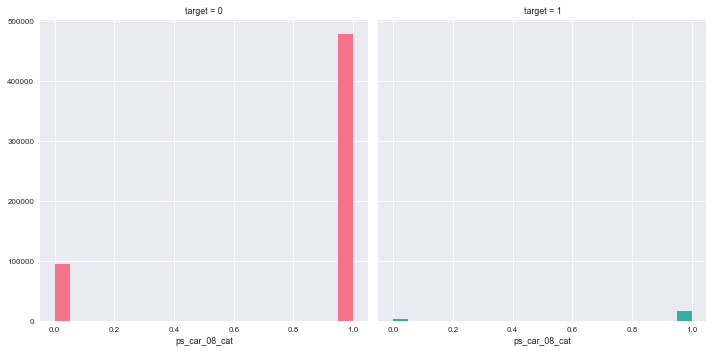

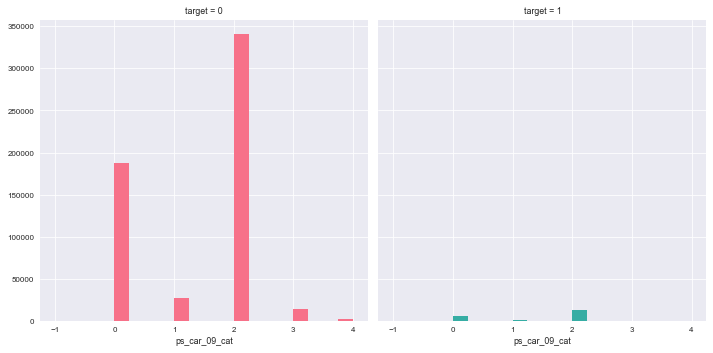

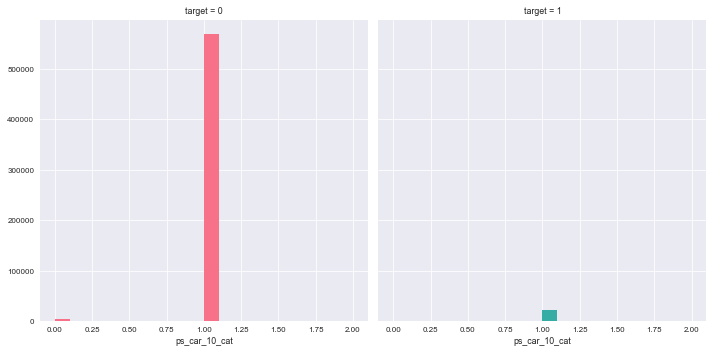

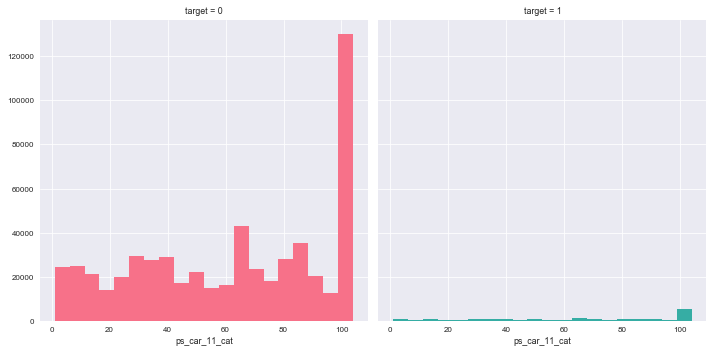

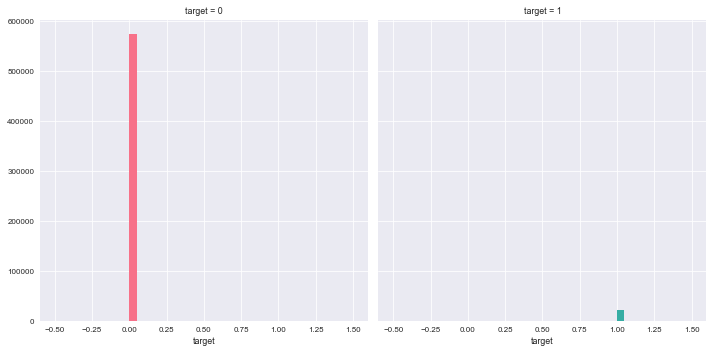

In [51]:
# produce histograms for all CATEGORICAL attributes
for col in X_cat_y.columns:
    g=sns.FacetGrid(X_cat_y,col='target',palette='husl',hue='target',size=5)
    g.map(plt.hist,col,bins=20);

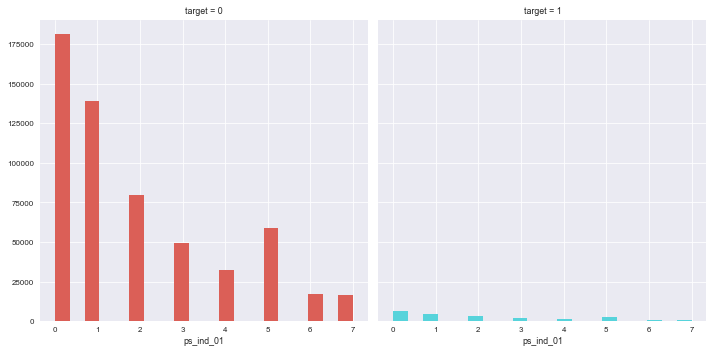

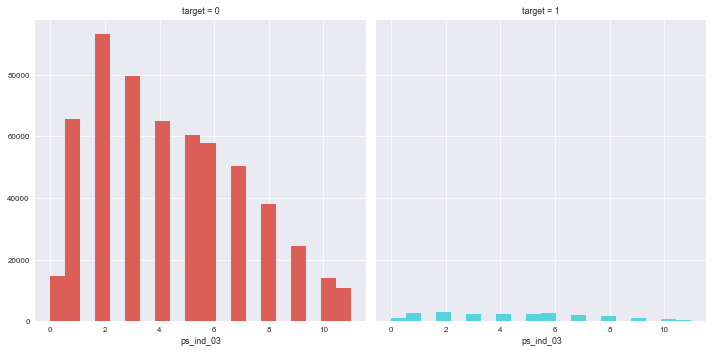

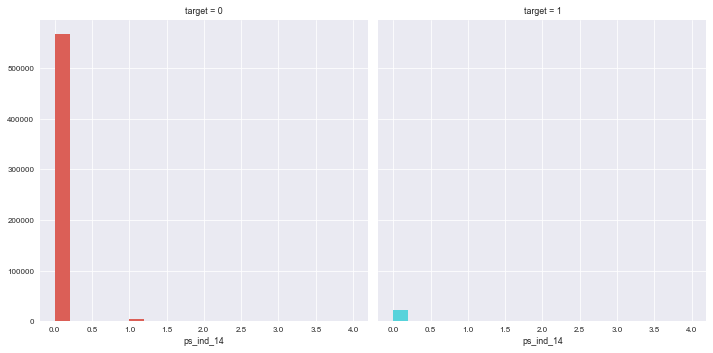

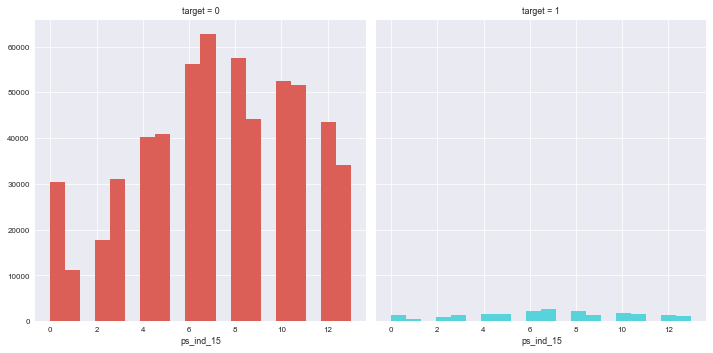

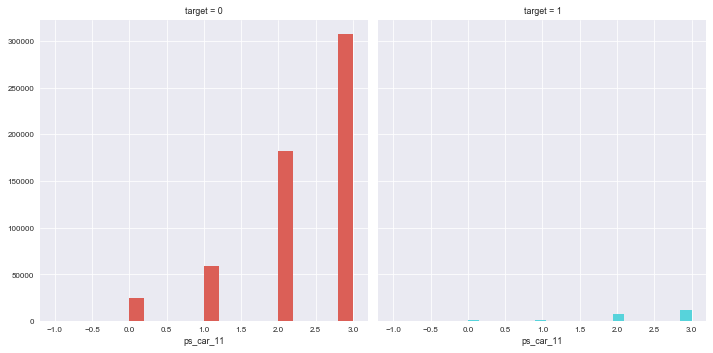

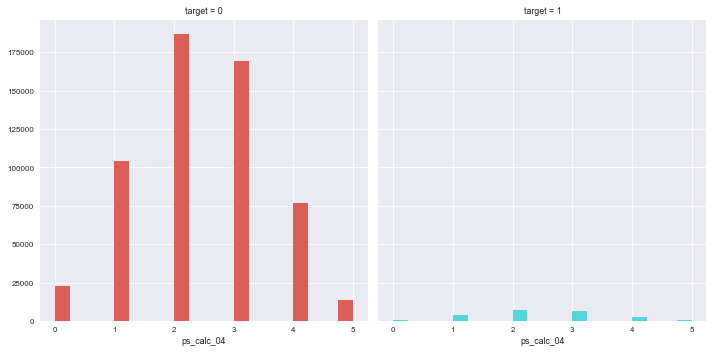

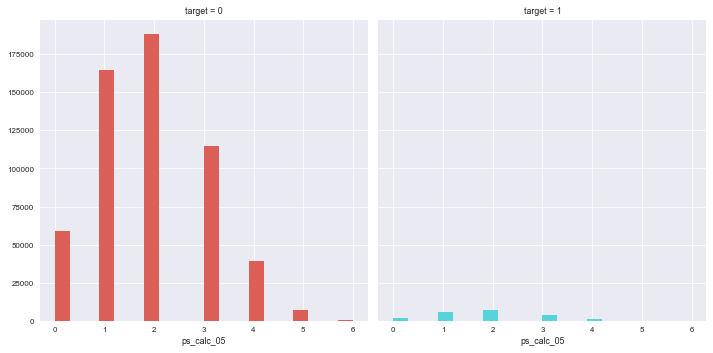

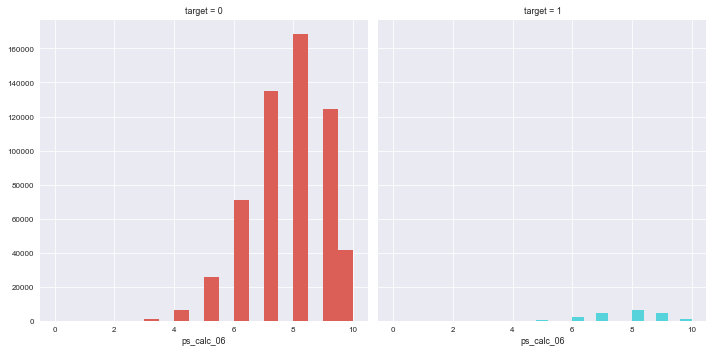

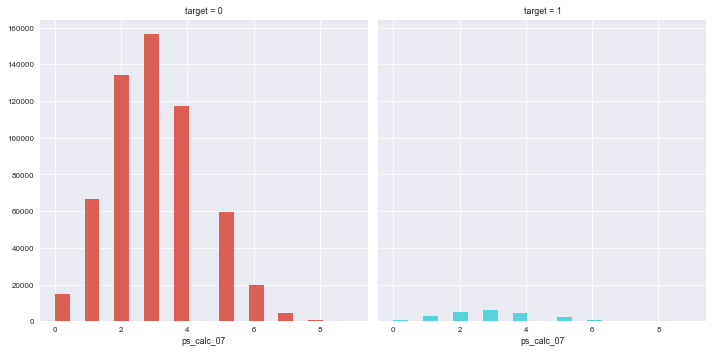

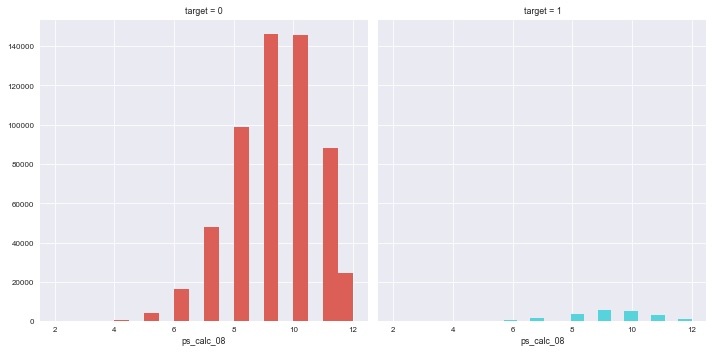

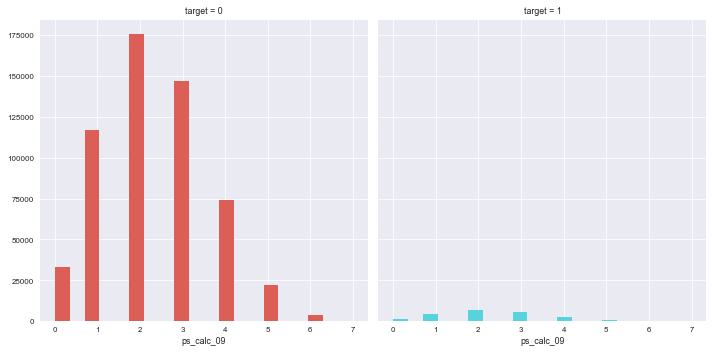

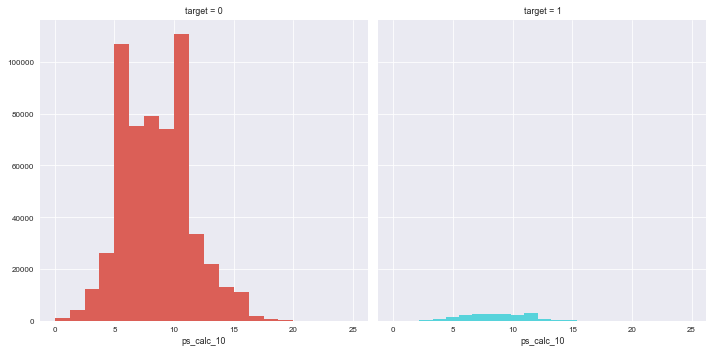

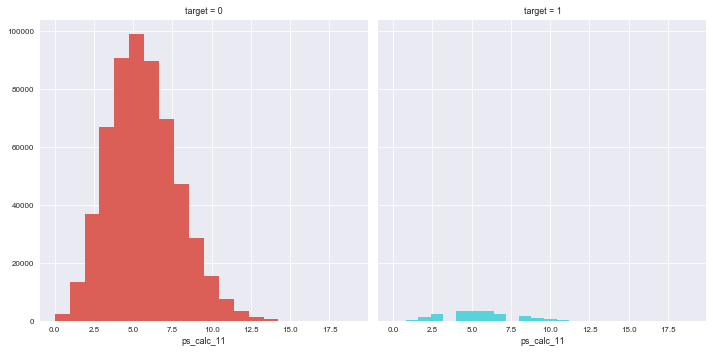

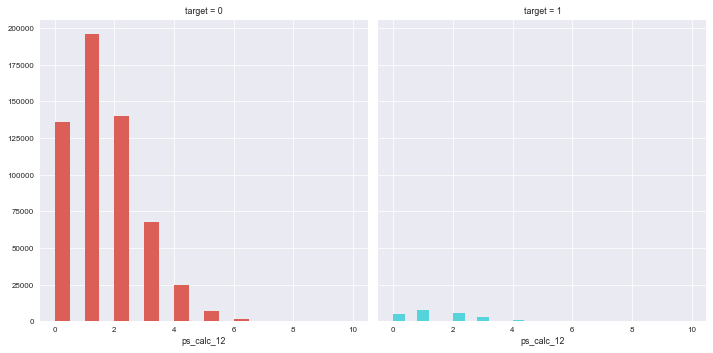

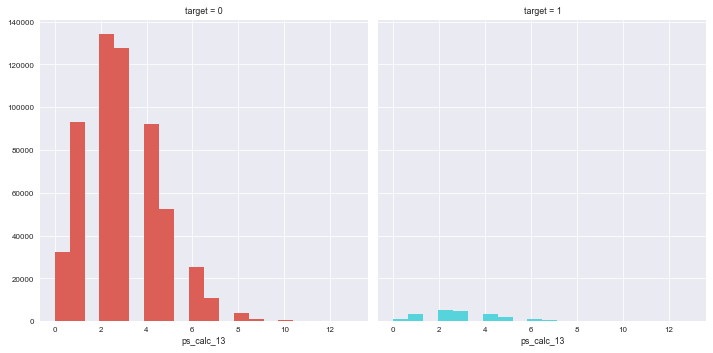

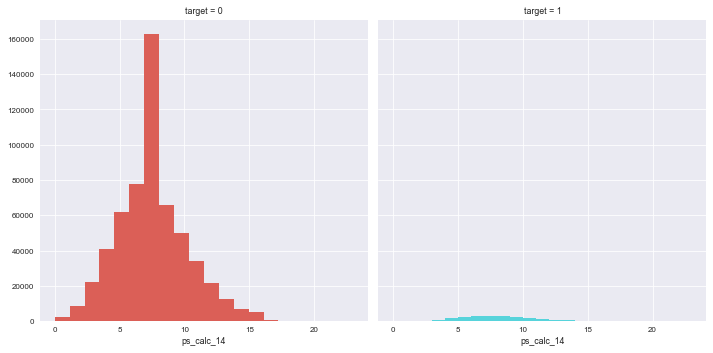

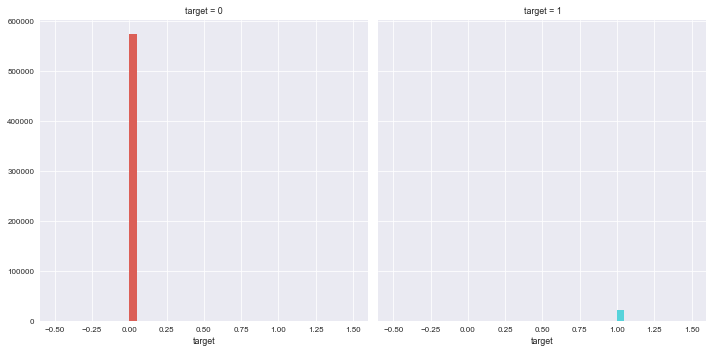

In [35]:
# produce histograms for all ORDINAL attributes
for col in X_ord_y.columns:
    g=sns.FacetGrid(X_ord_y,col='target',palette='hls',hue='target',size=5)
    g.map(plt.hist,col,bins=20);

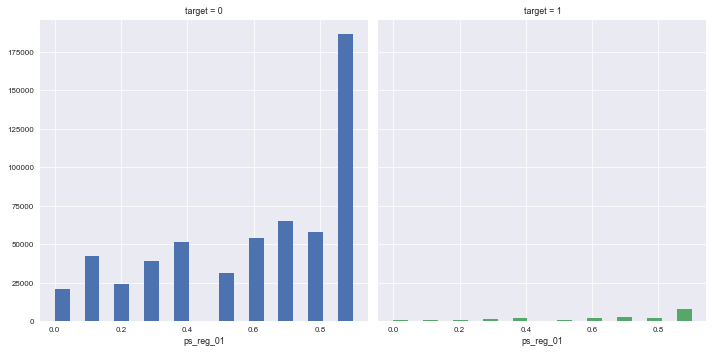

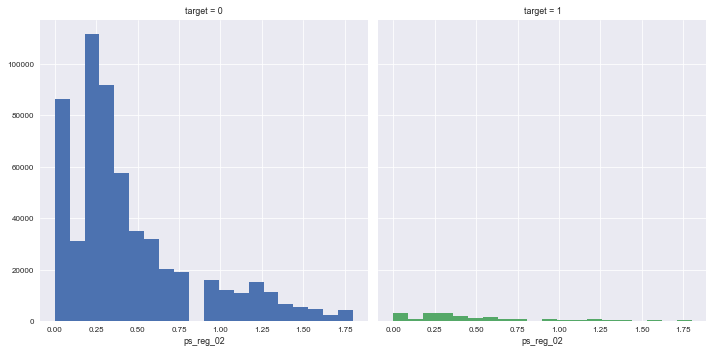

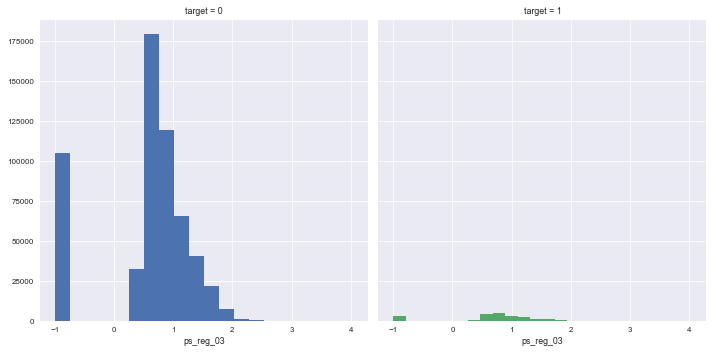

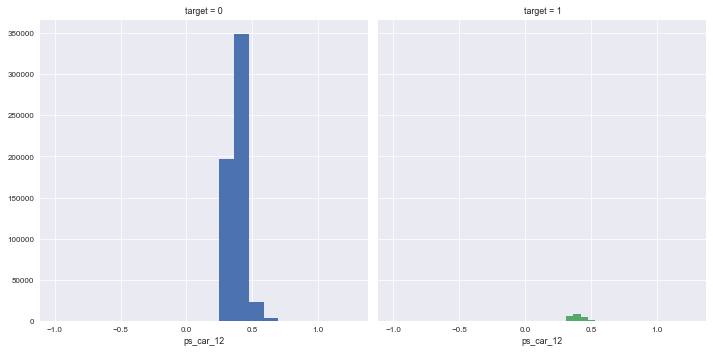

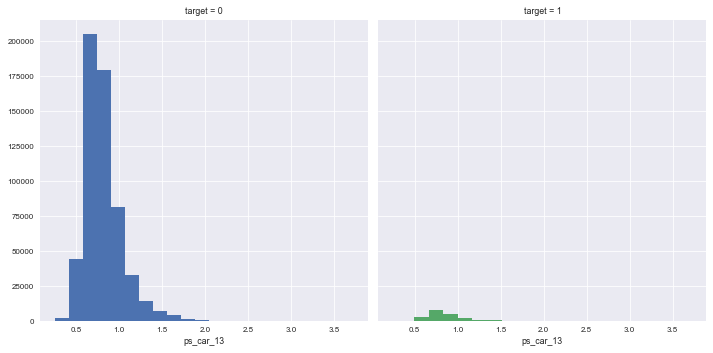

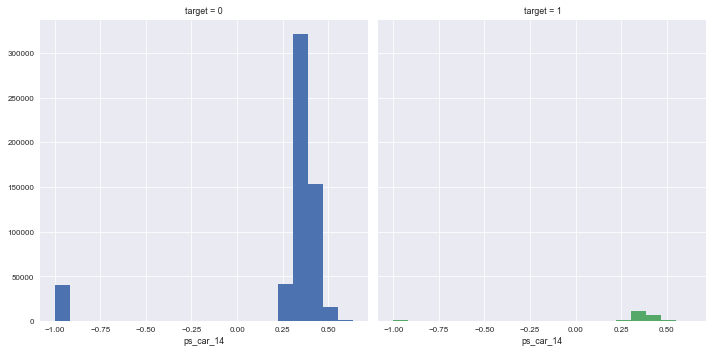

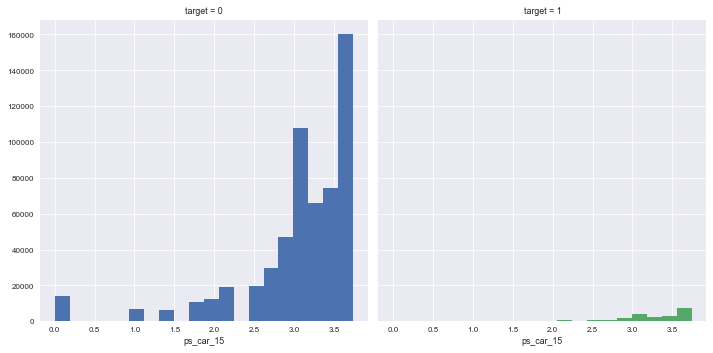

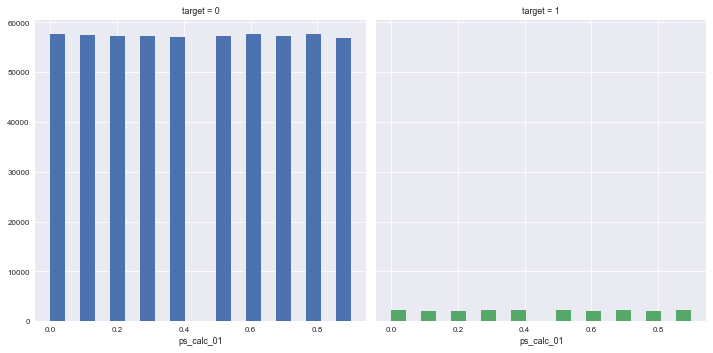

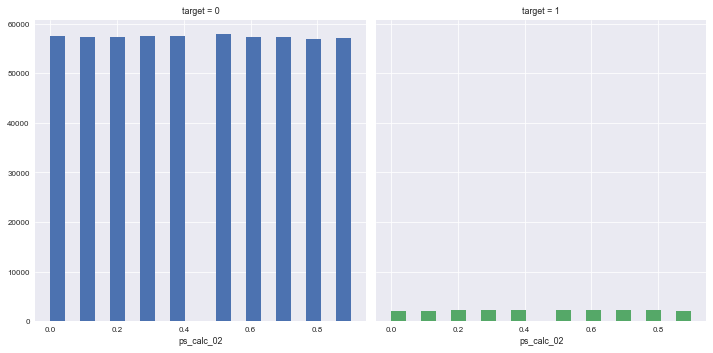

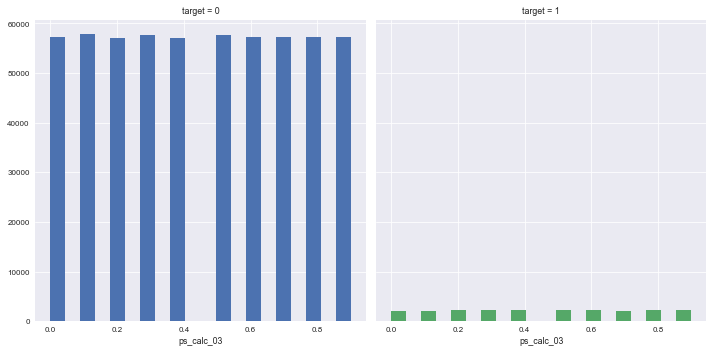

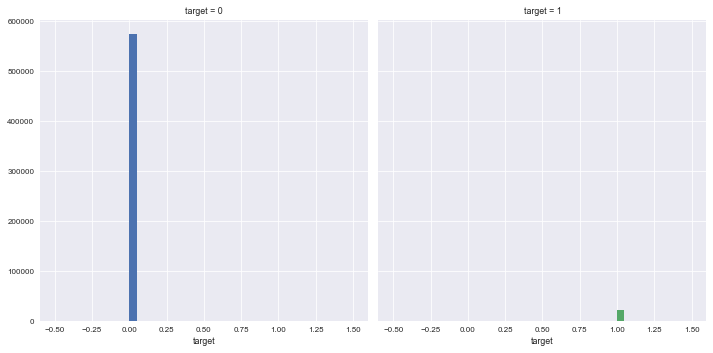

In [52]:
# produce histograms for all CONTINUOUS attributes 
for col in X_cont_y.columns:
    g=sns.FacetGrid(X_cont_y,col='target',hue='target',size=5)
    g.map(plt.hist,col,bins=20);

#### Correlations

In [ ]:
# product seaborn heatmap for REGION attributes
sns.heatmap(X_reg_y.corr(),cmap='Reds',annot=True);

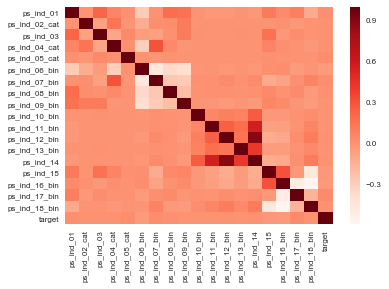

In [41]:
# produce seaborn heatmap for INDIVIDUAL attributes
sns.heatmap(X_ind_y.corr(),cmap='Reds',annot=False);

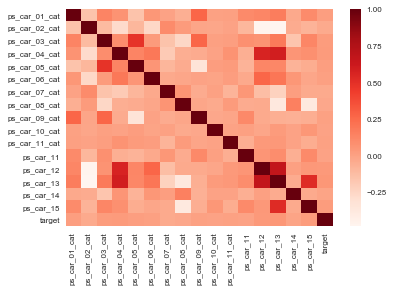

In [42]:
# produce seaborn heatmap for CAR attributes
sns.heatmap(X_car_y.corr(),cmap='Reds',annot=False);

In [ ]:
# produce seaborn heatmap for '_calc_' attributes
#sns.heatmap(X_calc_y.corr(),cmap='Greens',annot=False);

In [ ]:
# produce seaborn heatmap for Ind and Car attributes
#sns.heatmap(X_ind_car.corr(),cmap='Blues',annot=False);

In [ ]:
# produce seaborn heatmap for Ind and Reg attributes
#sns.heatmap(X_ind_reg.corr(),cmap='Blues',annot=False);

In [ ]:
# produce seaborn heatmap for Car and Reg attributes
#sns.heatmap(X_reg_car.corr(),cmap='Blues',annot=False);

#### Attribute/ Target Interactions 

In [ ]:
# produce seaborn pairplots for Regions attributes including target
sns.pairplot(X_reg_y,hue='target',kind='reg',diag_kind='kde',markers='+',palette='husl',size=5);

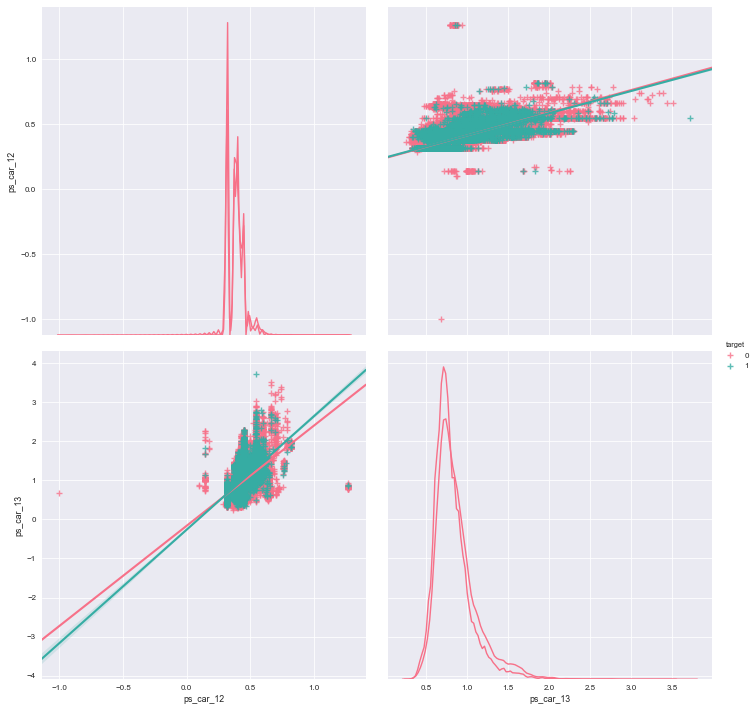

In [31]:
sns.pairplot(X_car_y,vars=['ps_car_12','ps_car_13'],hue='target',kind='reg',diag_kind='kde',
             markers='+',palette='husl',size=5);

In [ ]:
sns.swarmplot(x='ps_car_02_cat',y='ps_car_12',hue='target',data=X_car_y,palette='husl');

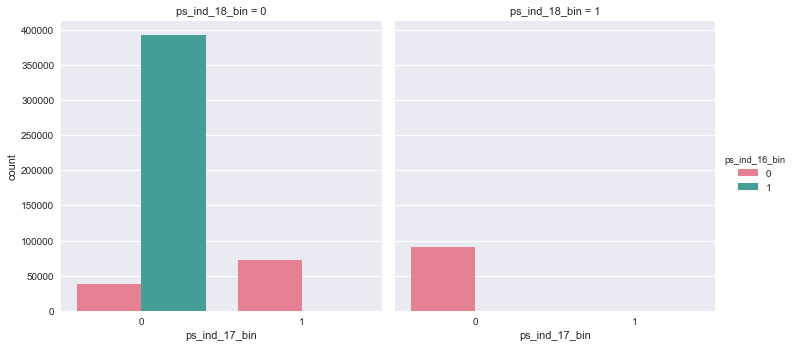

In [24]:
sns.factorplot(x='ps_ind_17_bin',hue='ps_ind_16_bin',col='ps_ind_18_bin',data=X_ind_y,kind='count',
               size=5,palette='husl');

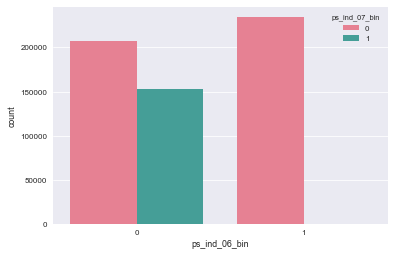

In [48]:
sns.countplot(x='ps_ind_06_bin',hue='ps_ind_07_bin',data=X_ind,palette='husl');

In [ ]:
temp=sns.pairplot(X_ind_y,vars=['ps_ind_15','ps_ind_16_bin','ps_ind_18_bin'],hue='target',kind='reg',diag_kind='kde',
             markers='+',palette='husl',size=5);

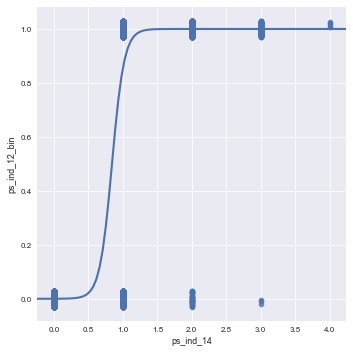

In [49]:
sns.lmplot(x='ps_ind_14',y='ps_ind_12_bin',data=X_ind,logistic=True,y_jitter=.03);

In [37]:
Counter((X_ind['ps_ind_14']))

Counter({0: 588832, 1: 5495, 2: 744, 3: 136, 4: 5})